# **Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import time
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import shutil

# **Create Dataframe**

In [2]:
base_path = 'CNN letter Dataset/'
classes = os.listdir('CNN letter Dataset')
filepaths = []
labels = []
for c in classes:
    flist = os.listdir(base_path + c)
    for f in flist:
        fpath = os.path.join(base_path + c + '/' + f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  35500    labels:  35500


In [3]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(35500,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

0    1030
7    1030
B    1030
V    1030
J    1030
8    1030
9    1030
6    1030
5    1030
4    1030
3    1030
2    1030
1    1030
T    1020
S    1020
R    1020
N    1020
M    1020
H    1020
G    1020
F    1020
C    1020
I    1010
K    1010
L    1010
P    1010
Q    1010
E    1010
D    1010
U    1010
A    1010
W    1010
X    1010
Y    1010
Z     810
Name: labels, dtype: int64


Dataset is a little inbalanced.

# **Visualize Images**

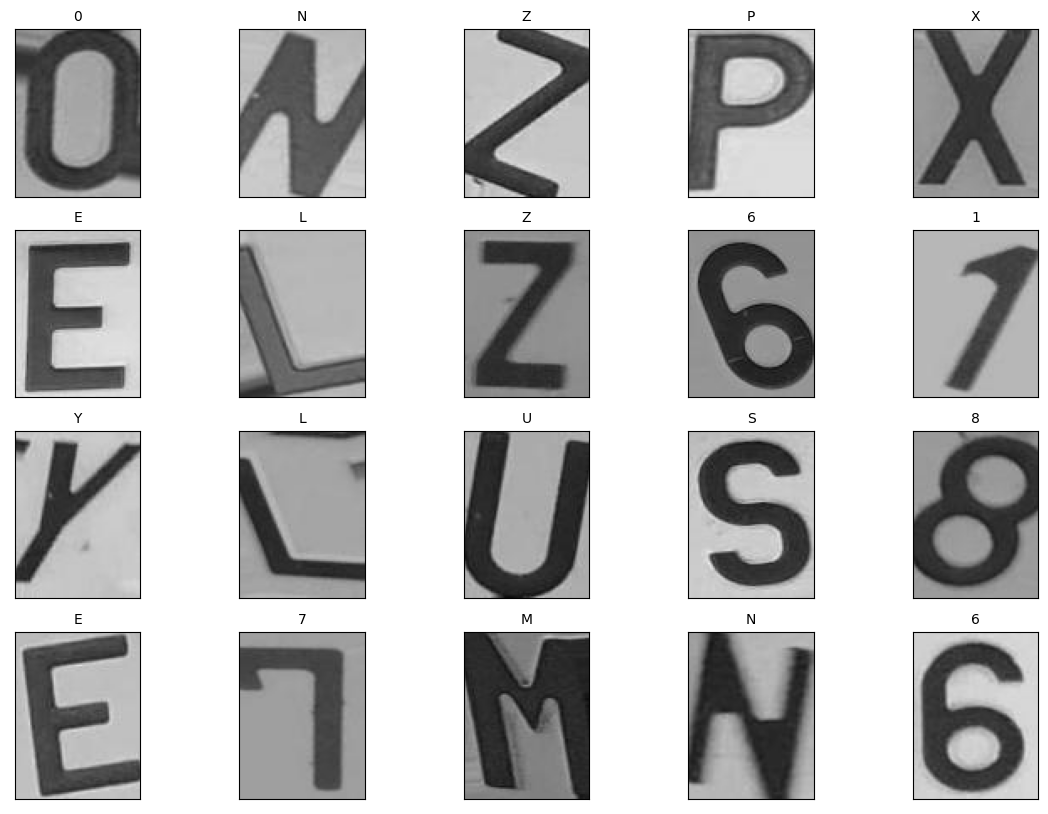

In [4]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"file_paths"]))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

Looks like the images are already augmented. 

# **Splitting Dataframe into Train, Valid, and Test**

In [5]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

6    910
8    906
4    891
3    890
7    883
B    882
0    879
J    879
Q    876
5    876
T    875
9    875
K    874
2    873
W    873
V    870
1    870
F    869
N    869
M    869
L    868
Y    868
E    866
R    866
S    866
U    866
I    865
G    865
A    862
H    861
D    860
C    857
P    850
X    848
Z    695
Name: labels, dtype: int64
X    117
1    112
V    109
H    109
G    109
C    107
A    106
B    106
R    105
2    105
P    103
J    103
N    103
D    101
K     99
F     97
0     97
7     96
I     95
M     95
9     95
3     94
5     93
S     92
U     91
E     89
T     89
L     89
Y     88
8     86
W     82
4     82
Q     78
Z     77
6     74
Name: labels, dtype: int64
S    62
5    61
9    60
P    57
4    57
C    56
M    56
Q    56
T    56
W    55
E    55
Y    54
0    54
F    54
U    53
L    53
2    52
V    51
7    51
I    50
H    50
D    49
R    49
1    48
J    48
N    48
3    46
6    46
G    46
X    45
A    42
B    42
Z    38
8    38
K    37
Name: labels, dtype: int64


# **Image Data Generator**

In [6]:
target_size=(299,299)
batch_size=64

In [7]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_gen = datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
valid_gen = datagen.flow_from_dataframe(valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
test_gen = datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 30352 validated image filenames belonging to 35 classes.
Found 3373 validated image filenames belonging to 35 classes.
Found 1775 validated image filenames belonging to 35 classes.


# **Building CNN Model**

In [8]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(299,299,3))
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(35, activation='softmax')
])

In [9]:
lr=0.001
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

# **Callbacks**

In [10]:
patience = 1
stop_patience = 3
factor = 0.5

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

# **Model Training**

In [ ]:
epochs = 10
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10



I could keep training past 10 epochs but the loss is already very small and the accuracy is 100%.

# **Predictions on Test Set**

In [12]:
best_model = model
best_model.load_weights('./classify_model.h5')
best_model.evaluate(test_gen)

28/28 [==============================] - 13s 456ms/step - loss: 3.1753e-05 - accuracy: 1.0000


[3.175323217874393e-05, 1.0]